In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, JLD2, OrdinaryDiffEq
using Plots

In [3]:
JLD2.@load("Ocean_geostrophic_velocity.jld2");
UV = interpolateVF(Lon, Lat, Time, UT, VT);

In [4]:
# Parameters
grid_resolution        = 200
quadrature_order       = 5
ϵ                      = 1                # perturbation
selected_ev            = 2
t_initial              = minimum(Time)
t_end                  = t_initial+80     # parameter value corresponding to ϵ=0
scale                  = 4
solver_tolerance       = 1e-8
solver                 = OrdinaryDiffEq.BS5();

In [5]:
T(x, param) = flow(interp_rhs, x, [t_initial, t_end + scale*param], p=UV,
        tolerance=solver_tolerance,solver=solver)[end]

T (generic function with 1 method)

In [6]:
LL, UR = (-4.0, -34.0), (6.0, -28.0)
lon_resolution = grid_resolution
lat_resolution = Integer(floor((UR[2] - LL[2])/(UR[1] - LL[1])*grid_resolution))
ctx, _ = regularTriangularGrid((lon_resolution, lat_resolution), 
        LL, UR, quadrature_order = quadrature_order);
bdata = getHomDBCS(ctx, "all");

In [7]:
M = assembleMassMatrix(ctx, bdata=bdata);

In [8]:
DT₀(x) = linearized_flow_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀, bdata=bdata);

 96.222469 seconds (94.81 M allocations: 5.387 GiB, 1.38% gc time)


In [9]:
# solve the linear system
@time λ₀, u₀ = eigs(K, M, which=:SM)
@assert all(imag.(u₀) .== 0)
@assert all(imag.(λ₀) .== 0)
u₀ = real.(u₀[:,selected_ev])
λ₀ = real.(λ₀[selected_ev])
u₀ = u₀ ./ sqrt(u₀'*M*u₀)        # L2 normalization
if u₀[Int(floor(0.75*lat_resolution*lon_resolution+0.75*lon_resolution))]<0
    u₀ = -u₀
end
λ₀

  3.417410 seconds (9.40 M allocations: 599.919 MiB, 4.03% gc time)


-12.373857713971377

In [10]:
# assemble the linear response matrix L
Adot = x -> linear_response_tensor(T, x, 0)
@time L = assembleStiffnessMatrix(ctx, Adot, bdata=bdata);

1128.834276 seconds (114.38 M allocations: 9.103 GiB, 0.16% gc time)


In [11]:
# solve the system for the derivative u_dot
lhs = [K-λ₀*M   -M*u₀
        u₀'*M      0]
rhs = [-L*u₀    ;  0]

@time b = lhs \ rhs
u_dot = b[1:end-1]
λ_dot = b[end]

  0.810835 seconds (2.38 M allocations: 170.763 MiB, 3.45% gc time)


-0.7276521684027272

In [12]:
# calculate the exact uϵ
DTϵ(x) = linearized_flow_autodiff(y -> T(y,ϵ) , x)
Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
Kϵ = assembleStiffnessMatrix(ctx, Aϵ, bdata=bdata)
λϵ, uϵ = eigs(Kϵ, M, which=:SM)
@assert all(imag.(uϵ) .== 0)
@assert all(imag.(λϵ) .== 0)
uϵ = real.(uϵ[:,selected_ev])
λϵ = real.(λϵ[selected_ev])
uϵ = uϵ ./ sqrt(uϵ'*M*uϵ)
if uϵ[Int(floor(0.75*lat_resolution*lon_resolution+0.75*lon_resolution))]<0
    uϵ = -uϵ
end
λϵ

-13.148537078191023

In [13]:
λ₀ + ϵ*λ_dot 

-13.101509882374105

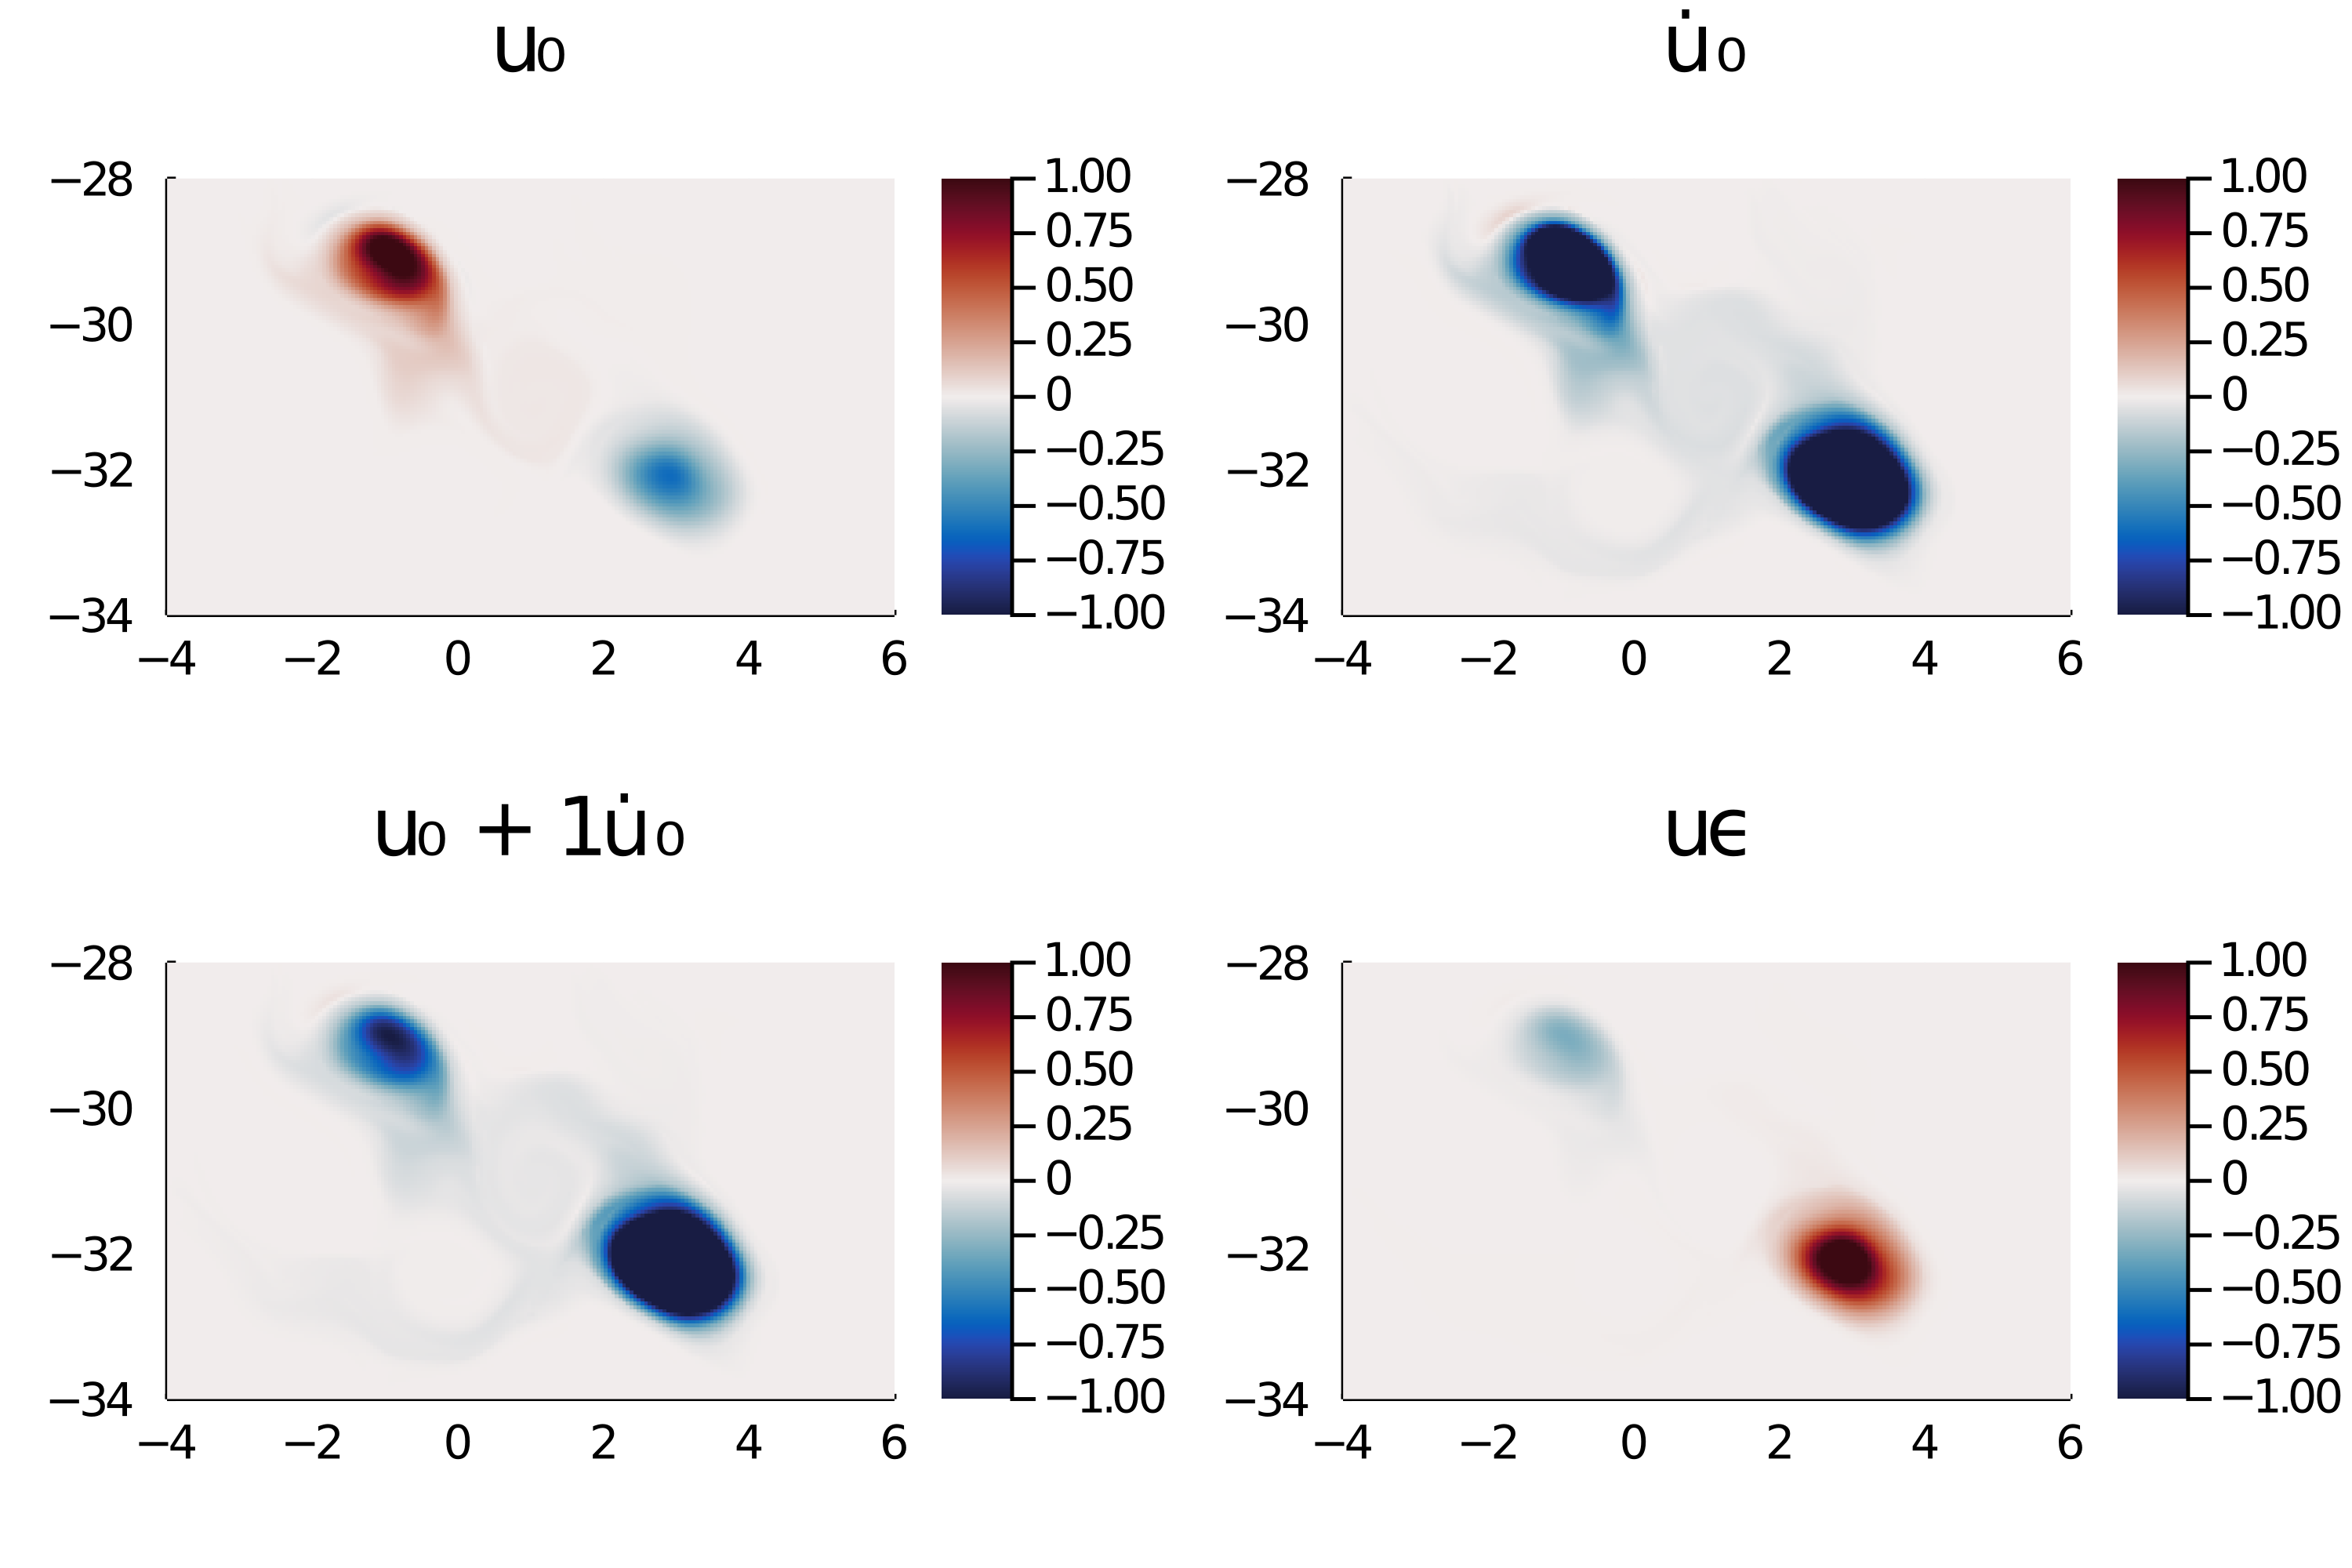

In [15]:
color =    :balance
xticks =   -4:2:6
yticks =   -34:2:-28
colorbar = :left
cmin =     -1
cmax =     1
cmin_lr =  -1
cmax_lr =  1
#unfortunately there is no option for colorbar ticks


original      = plot_u(ctx, u₀,           lon_resolution, lat_resolution, title="u₀", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
derivative    = plot_u(ctx, u_dot,       lon_resolution, lat_resolution, title="u̇ ₀", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
extrapolated  = plot_u(ctx, u₀ + ϵ*u_dot, lon_resolution, lat_resolution, title="u₀ + $(ϵ)u̇ ₀", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
exact         = plot_u(ctx, uϵ,          lon_resolution, lat_resolution, title="uϵ", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
Plots.plot(original,derivative,extrapolated,exact, fmt=:png, dpi=500)